In [5]:
import jeppesen_pipeline as jp

TDMS_PATH  = r"D:\ML algoritme tl anfaldsdetektion vha HRV\ePatch data from Aarhus to Lausanne\Patients ePatch data\Patient 2\recording 1\Patient_2_1.tdms"
INDEX_PATH = r"D:\ML algoritme tl anfaldsdetektion vha HRV\ePatch data from Aarhus to Lausanne\Patients ePatch data\Patient 2\recording 1\Patient_2_1.tdms_index"

res = jp.run_pipeline_from_tdms_auto(
    tdms_path=TDMS_PATH,
    fs_override=512.0,           # Sæt denne hvis TDMS mangler wf_increment/dt/SamplingRate
    index_path=INDEX_PATH,       # valgfri: giver evt. absolutte timestamps i meta
    rpeak_mode="labview",        # 1:1 med VI’en
    window_beats=100,
    auto_baseline_beats=20000,
    auto_pct=99.5,
    plots=True,
    out="patient2_rec1"
)

res["features"].head(), res["detections"].head()


AttributeError: module 'jeppesen_pipeline' has no attribute 'run_pipeline_from_tdms_auto'

In [6]:
import jeppesen_pipeline as jp
print(jp.__file__)
print(hasattr(jp, "run_pipeline_from_tdms_auto"))


c:\Users\kvjkv\.vscode\Epilepsy_MasterThesis\jeppesen_pipeline.py
False


In [7]:
import importlib, jeppesen_pipeline as jp
jp = importlib.reload(jp)
print(jp.__file__)
print(hasattr(jp, "run_pipeline_from_tdms_auto"))


c:\Users\kvjkv\.vscode\Epilepsy_MasterThesis\jeppesen_pipeline.py
True


In [18]:
TDMS_PATH  = r"D:\ML algoritme tl anfaldsdetektion vha HRV\ePatch data from Aarhus to Lausanne\Patients ePatch data\Patient 2\recording 1\Patient_2_1.tdms"
INDEX_PATH = r"D:\ML algoritme tl anfaldsdetektion vha HRV\ePatch data from Aarhus to Lausanne\Patients ePatch data\Patient 2\recording 1\Patient_2_1.tdms_index"

# res = jp.run_pipeline_from_tdms_auto(
#     tdms_path=TDMS_PATH,
#     fs_override=512.0,         # brug hvis TDMS ikke har wf_increment/dt/SamplingRate
#     index_path=INDEX_PATH,     # valgfri
#     rpeak_mode="labview",
#     window_beats=100,
#     auto_baseline_beats=20000,
#     auto_pct=99.5,
#     plots=True,
#     out="patient2_rec1"
# )
# res["features"].head(), res["detections"].head()

# 1) Læs TDMS til arrays
x, t_sec, fs, *_ = jp.read_tdms_auto(TDMS_PATH, fs_override=512.0)

# 2) Slice på tidsakse
start_s = 5000.0
dur_s   = 1200.0
i0 = int(start_s * fs)
i1 = int((start_s + dur_s) * fs)

x_win = x[i0:i1]
t_win = None  # eller t_sec[i0:i1] hvis du vil

# 3) Kør pipelinen på slice
res = jp.run_pipeline_from_ecg(
    ecg=x_win, fs=fs, t=t_win,
    rpeak_mode="labview",
    window_beats=100,
    auto_baseline_beats=0,
    plots=True, out="slice_run_auto"
)


In [19]:
print(res.keys())
print(res["peaks"])

# print(res["features"].head())
print(res["rr_sec"])

dict_keys(['peaks', 'rr_sec', 't_rr', 'features', 'detections', 'meta'])
[   725    917   1935   2817   3105   3577   3865   4254   5417   5705
   5892   6178   7076   7487   8936  10902  11181  11471  11629  13462
  19556  19727  22901  23159  23524  23782  23948  32162  32440  32718
  32998  39140  39428  45782  49637  49928  54749  54926  55214  55608
  55894  56066  56342  61035  61205  62903  66022  74827  75107  75491
  75643  91910  92078  95416 123335 132998 137255 137819 139806 141661
 159383 159863 175028 175210 175620 176210 176513 176812 176992 177396
 177690 177961 178265 178551 178834 179008 179398 179682 179963 180132
 180527 180814 181393 182575 182866 185742 191465 191756 192913 203658
 216030 216322 235217 278682 278978 279161 279447 280548 304844 305181
 305416 305737 306739 320677 320882 342869 343070 343390 343714 344022
 366791 367086 367392 408048 408223 408506 408794 431806 431989 432487
 433267 433535 434310 438481 438753 439131 439326 442614 452251 456258
 460

In [ ]:
import numpy as np
import pandas as pd

# 1) Peaks (samples og sekunder):
fs_used = res["meta"].get("target_fs") or res["meta"].get("fs_used")  # hvis du brugte v3-script: ellers bare din fs
if fs_used is None:
    # Hvis meta ikke har fs, brug den du gav ind (fx fs_override eller kendt fs)
    fs_used = 512.0

peaks = res["peaks"].astype(int)
peaks_s = peaks / float(fs_used)
df_peaks = pd.DataFrame({"peak_sample": peaks, "peak_time_s": peaks_s})
df_peaks.to_csv("patient2_rec1_peaks.csv", index=False)

# 2) RR i sekunder:
df_rr = pd.DataFrame({"t_rr_s": res["t_rr"], "rr_s": res["rr_sec"]})
df_rr.to_csv("patient2_rec1_rr.csv", index=False)

# 3) Features og detektioner:
res["features"].to_csv("patient2_rec1_features.csv", index=False)
res["detections"].to_csv("patient2_rec1_detections.csv", index=False)


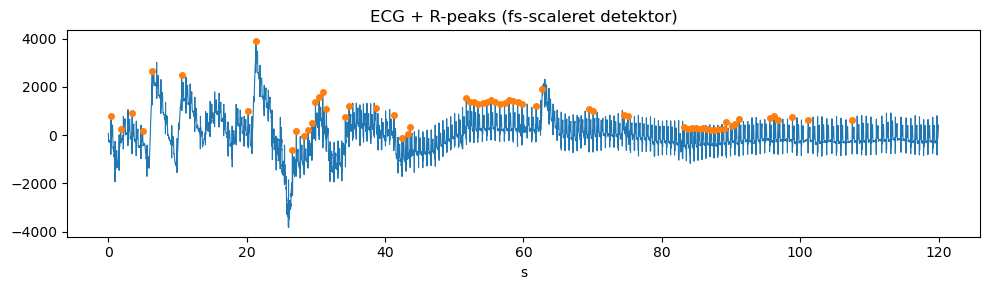

In [20]:
#fs-skalerede parametre (udsnit)
import numpy as np
import matplotlib.pyplot as plt
import jeppesen_pipeline as jp

# a) hent et udsnit (x_win, fs)
x, t_sec, fs, *_ = jp.read_tdms_auto(TDMS_PATH, fs_override=512.0)
start_s, dur_s = 600.0, 120.0
i0, i1 = int(start_s*fs), int((start_s+dur_s)*fs)
x_win = x[i0:i1]

# b) SKALÉR sample-baserede konstanter fra 256 Hz til din fs
scale = fs/256.0
params = jp.LVParams(
    fs = fs,
    fwd_bwd_radius_samp = int(round(15*scale)),
    delta_thresh_samples = int(round(35*scale)),
    # resten (i sekunder) må ikke røres: refractory_s=0.25, win_s=2.0 osv.
)

# c) detekter peaks med LabVIEW-mode + skalerede parametre
detector = jp.LabVIEWRpeak(params)
peaks = detector.detect(x_win)

# d) lav RR og gem hurtigt til CSV til 1:1 med LabVIEW
rr_sec, t_rr = jp.rr_from_peaks(peaks, fs)
import pandas as pd
pd.DataFrame({"peak_sample":peaks, "peak_time_s":peaks/fs}).to_csv("slice_peaks_scaled.csv", index=False)
pd.DataFrame({"t_rr_s":t_rr, "rr_s":rr_sec}).to_csv("slice_rr_scaled.csv", index=False)

# e) kig visuelt: ECG + peaks
t = np.arange(len(x_win))/fs
plt.figure(figsize=(10,3))
plt.plot(t, x_win, lw=0.8)
plt.plot(peaks/fs, x_win[peaks], "o", ms=4)
plt.xlabel("s"); plt.title("ECG + R-peaks (fs-scaleret detektor)")
plt.tight_layout(); plt.show()


In [21]:
# Tjek signalkonventioner (polaritets-flip og filter)
# grov check: er "store" peaks overvejende negative?
s = x_win
top = np.percentile(s, 99)
bot = np.percentile(s, 1)
print("pos amp ~", top, "neg amp ~", abs(bot))
# hvis abs(bot) >> top, så prøv:
if abs(bot) > 1.2*top:
    x_win = -x_win


pos amp ~ 2214.2196688792255 neg amp ~ 1671.343160143434


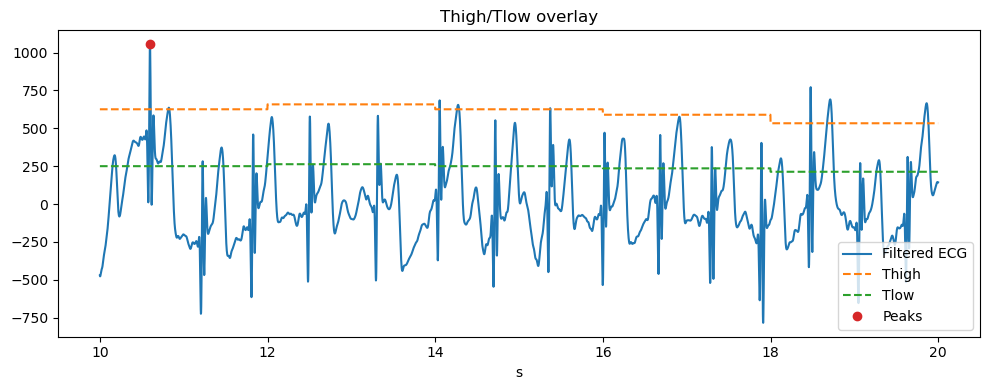

In [22]:
# lille hjælpefunktion til at få Thigh/Tlow ud (kopierer interne trin)
def lv_thresholds_for_plot(ecg, fs, params):
    bp = jp.bandpass_filter(ecg, fs, 0.5, 32.0, 4)
    L = int(round(params.win_s*fs))
    rect = np.maximum(bp, 0.0)
    wmax = []
    edges = []
    for st in range(0, len(rect), L):
        en = min(len(rect), st+L)
        wmax.append(np.max(rect[st:en]) if en>st else 0.0)
        edges.append((st,en))
    wmax = np.array(wmax)

    # Thigh over vinduer (median af seneste 8, * 0.75)
    thigh_w = np.zeros_like(wmax)
    for k in range(len(wmax)):
        if k == 0: thigh_w[k] = params.thigh_alpha*wmax[0]
        else:
            lo = max(0, k-8)
            med = np.median(wmax[lo:k]) if k>0 else wmax[k]
            thigh_w[k] = params.thigh_alpha*med

    # Opskalér til sample-niveau
    thigh = np.zeros(len(bp))
    for k,(st,en) in enumerate(edges):
        thigh[st:en] = thigh_w[k]
    tlow = 0.4*thigh
    return bp, thigh, tlow

bp, thigh, tlow = lv_thresholds_for_plot(x_win, fs, params)

# Plot et kritisk område
view_s = (start_s+10, start_s+20)  # vælg dit problem-interval
j0, j1 = int((view_s[0]-start_s)*fs), int((view_s[1]-start_s)*fs)
tt = np.arange(len(x_win))/fs

plt.figure(figsize=(10,4))
plt.plot(tt[j0:j1], bp[j0:j1], label="Filtered ECG")
plt.plot(tt[j0:j1], thigh[j0:j1], '--', label="Thigh")
plt.plot(tt[j0:j1], tlow[j0:j1],  '--', label="Tlow")
pwin = peaks[(peaks>=j0)&(peaks<j1)]
plt.plot(tt[pwin], bp[pwin], 'o', label="Peaks")
plt.legend(); plt.xlabel("s"); plt.title("Thigh/Tlow overlay")
plt.tight_layout(); plt.show()
